<div style="background-color: lightblue; padding: 10px; border-radius: 5px;">

## QSAR-based classification of molecular toxicity using Chemical descriptors, Molecular Fingerprints and Random Forest.

**Goal** Train and evaluate a multi-task classifier (e.g., LogisticRegression, RandomForest, XGBoost classifier) to identify toxic v non-toxic molecules (for a given assay). The input is given by a set of physicochemical descriptors or/and the fingerprints representing such modecule.

**QSAR** (Quantitative Structural-Activity Relationship): Bulding a quantitative relationship between molecular structure (e.g., molecular fingerprints or descriptors) and biological function (e.g., toxicity, activity, solubility)
</div>

<div style="background-color: lightblue; padding: 10px; border-radius: 5px;">
    
**Training dataset** : goal is to predict chemical toxicity using computational methods - such as QSAR, ML, deep learning. Widely used in ChemInfo, has diverse chemical space.

* ~7,800 molecules represented by SMILES strings, each with the outputs from 12 binary classification assays. Labels are either 1 = active, 0 = inactive or NaN = not tested

* Assays include nuclear receptor signaling pathways (7 assays) and stress response pathways (5 assays)
</div>

<div style="background-color: lightblue; padding: 10px; border-radius: 5px;">
    
**Tools**
* `scikit-learn` and `pandas`
* **Core cheminfo**: `RDKit` **smiles, descriptors, fingerprints** to automate molecular representation and generate the input to the classifier
* **evaluation/interpretation metrics**: accuracy, recall, f1, precision, confusion matrix, **ROC-AUC**
</div>

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import joblib
import os

from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, auc, roc_curve, confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

import xgboost as xgb

# Set global font sizes across the notebook
mpl.rcParams['axes.titlesize'] = 18       # Title font size
mpl.rcParams['axes.labelsize'] = 16       # Axis label font size
mpl.rcParams['xtick.labelsize'] = 14      # X-axis tick label font size
mpl.rcParams['ytick.labelsize'] = 14      # Y-axis tick label font size
mpl.rcParams['legend.fontsize'] = 16      # Legend font size
#mpl.rcParams['figure.titlesize'] = 16     # Figure title size

# Tox21 da MoleculeNet, downloaded from the internet, sicne the original link/url comes with restrictions
dataset = './tox21.csv'
df = pd.read_csv(dataset)

# Print columns
print(list(df.columns))  # print first few databse columns (SMILES + target)

print('Number of molecules in dataset = ' + str(df.shape[0]))
print('Number of assays to use for classification = ' + str(df.shape[1]-2))

['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53', 'mol_id', 'smiles']
Number of molecules in dataset = 7831
Number of assays to use for classification = 12


In [2]:
def compute_descriptors(mol):
    
    """ Helper function: compute descriptors from mol object, as from SMILES representation 
        There are human-readable, interpretable and carry physicochemical information
    """
 
    desc = {}
    desc['MolWt'] = Descriptors.MolWt(mol)        # here we know the "Descriptors" functions commands explicitly
    desc['LogP'] = Descriptors.MolLogP(mol)
    desc['NumHDonors'] = Descriptors.NumHDonors(mol)
    desc['NumHAcceptors'] = Descriptors.NumHAcceptors(mol)
    desc['TPSA'] = Descriptors.TPSA(mol)
    desc['NumRotatableBonds'] = Descriptors.NumRotatableBonds(mol)
    
    return desc

# Compute ECFP4 fingerprint (bit vector), Morgan fingerptins with a radius of 2
def compute_ecfp4(mol, nBits=2048):
    
    """ Compute 2048 bit fingerprints out of mol
        These are not human readable, not easily interpretable; but capture struturals subgraphs info
    """
    
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=nBits)
    arr = np.zeros((1,), dtype=int)
    AllChem.DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

# featurizer: prepare features for the regression
def featurizer(smiles_list):
    
    """ Take in list of SMILES representation for different molecules, and return Chem descriptors &
        Fingerprints quantitative representations
    
        OUTPUT: * features (dict), dictionary of features 
                * valid_feature_idx (list), list of indexes of molecules that are legit
    """
    
    features = []
    valid_feature_idx = []
    
    for i, smi in enumerate(smiles_list):
        mol = Chem.MolFromSmiles(smi)
        if mol:
            desc = compute_descriptors(mol)   # this is a dictionary already
            fp = compute_ecfp4(mol)
            desc.update({f'ECFP_{j}': fp[j] for j in range(len(fp))})   # add fingerprint dictionary entries
            features.append(desc)
            valid_feature_idx.append(i)
        else:
            print(f"Invalid SMILES skipped: {smi}")
    return features, valid_feature_idx

In [3]:
def grid_search(model, param_grid):

    """ Run grid search on model hyper-parameters to identify the best model, return the best model object """
    
    print('Running ' + str(model) + ' for fitting...')
    # Grid search with 5-fold cross-validation: this is built-in in scikit-learn
    grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,   # dictionary
                           cv=5,
                           scoring='roc_auc',
                           n_jobs=-1,
                           verbose=1)
    # Fit the model
    grid_search.fit(X_train, y_train)

    # extract best model
    best_model = grid_search.best_estimator_

    # # test BEST MODEL model on test_set
    y_pred = best_model.predict(X_test)

    print("Best Parameters:", grid_search.best_params_)
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # extract best estimator/best model out of those tested
    return best_model, y_pred

In [4]:
### select regressor and parameters here

regressors = {"RandomForestClassifier": RandomForestClassifier(random_state=42),
              "LogisticRegression": LogisticRegression(random_state=42)}

param_grid = {"RandomForestClassifier": {'n_estimators': [10,25,50,100,200,300]},
             "XGBoost": {'n_estimators': [100, 300],
                         'max_depth': [5, 10, None],
                         'min_samples_split': [2, 5],
                         'min_samples_leaf': [1, 3],
                         'max_features': ['sqrt', 'log2'],
                         },
             "LogisticRegression": {'max_iterations': [5,25,500,100,250,500,1000]}}

### Prepare dataset: get and clean features (some may be NaN), get and clean classification labels (classification might have not been unambiguous or successful for a given molecule)

In [5]:
smiles_list = df['smiles'].values   #list of smiles representations for the molecules in the dataset

# Prepare features dataframe: appending descriptors & fingerprints, all together; both continuous and discrete vars
features, valid_idx = featurizer(smiles_list)
    
# convert to pd Dataframe: features is a list of dictionaries: to preseve column identity and labels
X = pd.DataFrame(features)
feature_names = list(X.columns)

task = 'NR-AR'

# Prepare features (X_task) and (classification) labels (y_task), by removing NaNs
# a given assay might have been inconclusive (NaN) for a given molecule; remove those molecules
y = df[task]
y = y[valid_idx]   # important to only retain legit/valid molecules
print(X.shape, y.shape)

[21:48:10] DEPRECATION WARNING: please use MorganGenerator
[21:48:10] DEPRECATION WARNING: please use MorganGenerator
[21:48:10] DEPRECATION WARNING: please use MorganGenerator
[21:48:10] DEPRECATION WARNING: please use MorganGenerator
[21:48:10] DEPRECATION WARNING: please use MorganGenerator
[21:48:10] DEPRECATION WARNING: please use MorganGenerator
[21:48:10] DEPRECATION WARNING: please use MorganGenerator
[21:48:10] DEPRECATION WARNING: please use MorganGenerator
[21:48:10] DEPRECATION WARNING: please use MorganGenerator
[21:48:10] DEPRECATION WARNING: please use MorganGenerator
[21:48:10] DEPRECATION WARNING: please use MorganGenerator
[21:48:10] DEPRECATION WARNING: please use MorganGenerator
[21:48:10] DEPRECATION WARNING: please use MorganGenerator
[21:48:10] DEPRECATION WARNING: please use MorganGenerator
[21:48:10] DEPRECATION WARNING: please use MorganGenerator
[21:48:10] DEPRECATION WARNING: please use MorganGenerator
[21:48:10] DEPRECATION WARNING: please use MorganGenerat

(7831, 2054) (7831,)


In [6]:
# clean the labels
y = y.dropna()
print(y.index)

X_task = X.loc[y.index]
y_task = y.astype(int).values

print(X_task.shape, y_task.shape)

Index([   0,    1,    3,    4,    5,    6,    7,    8,   10,   11,
       ...
       7820, 7821, 7822, 7823, 7824, 7825, 7827, 7828, 7829, 7830],
      dtype='int64', length=7265)
(7265, 2054) (7265,)


In [31]:
# other strategy to get the preprocessing in place

fps = df['smiles'].apply(smiles_to_ecfp)   # this is a syntax to apply the function to all entries of df['smiles']
fps = fps.dropna()    # remove any row (i.e., any molecule)  that is invalid
print((df.index == fps.index).all())

# synchronize df after removing NaN data: revove the same rows
df = df.loc[fps.index]
X = np.stack(fps.values)
print('Number of cleaned molecules to be used = ' + str(X.shape[0]))

# Scegli un task di tossicità da testare
task = 'NR-ER'

# Prepare features (X_task) and (classification) labels (y_task), by removing NaNs
# a given assay might have been inconclusive (NaN) for a given molecule; remove those molecules
df_task = df[[task]].dropna()
print(df_task.shape)   #.index is an array containing the rows that do not come with NaN, so are legit

X_task = X[df_task.index]
y_task = df_task[task].astype(int).values   # this is a series now
print(y_task, y_task.shape, X_task.shape)


print('Number of samples  = ' + str(y_task.shape))
print('Number of features = ' + str(X_task.shape[1]))

assert X_task.shape[0] == y_task.shape[0]

### Define train and test subsets, define and optimize classifier, find best model via hyperparameter tuning

In [7]:
regres_model = "RandomForestClassifier"

In [8]:
# split data into training and test set (use scikit-learn)
X_train, X_test, y_train, y_test = train_test_split(X_task, y_task, test_size=0.2, random_state=42)


best_model, y_pred = grid_search(regressors[regres_model], param_grid[regres_model])


Running RandomForestClassifier(random_state=42) for fitting...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'n_estimators': 300}
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1389
           1       0.91      0.47      0.62        64

    accuracy                           0.97      1453
   macro avg       0.94      0.73      0.80      1453
weighted avg       0.97      0.97      0.97      1453



In [9]:
print('Evaluation metrics:')

# compute a number of things that are then featured in the confusion matrix
print(" Accuracy: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("Precision: {:.2f}".format(precision_score(y_test, y_pred)))
print("   Recall: {:.2f}".format(recall_score(y_test, y_pred)))
print(" F1 Score: {:.2f}".format(f1_score(y_test, y_pred)))

Evaluation metrics:
 Accuracy: 0.97
Precision: 0.91
   Recall: 0.47
 F1 Score: 0.62


### Plot confusion matrix of the problem

Plot confusion matrix relating to the classification...


<Figure size 400x400 with 0 Axes>

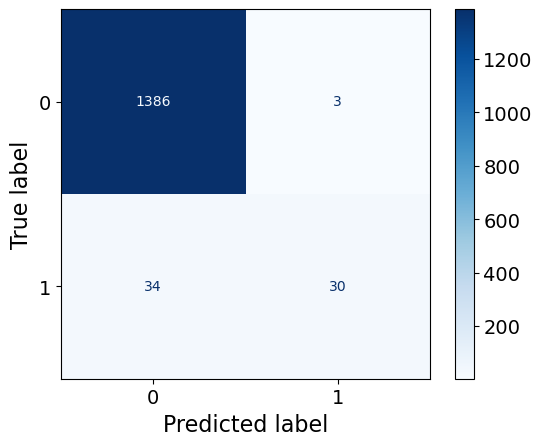

In [11]:
# Plot confusion matrix
print('Plot confusion matrix relating to the classification...')
fig = plt.figure(figsize = (4,4))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(cmap='Blues')

### this is a classification problem, let's plot the ROC curve and compute the Area Under the Curve

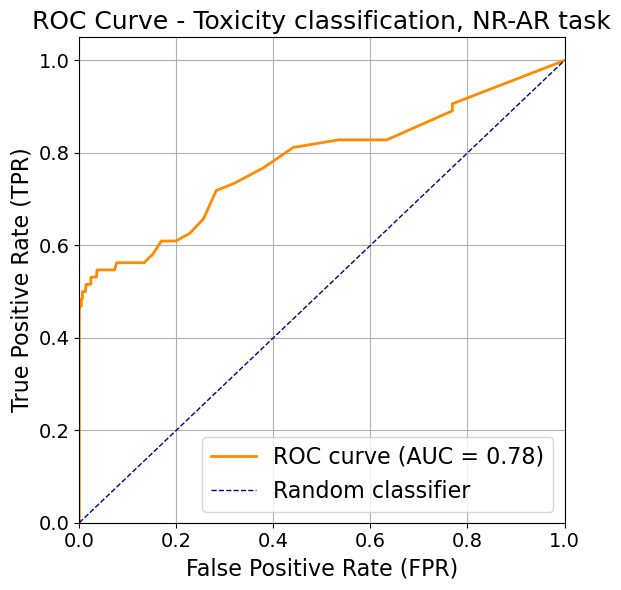

In [13]:
# We can automatically compute the predicted probabilities, before thresholding to 0 or 1
y_proba = best_model.predict_proba(X_test)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Compute the AUC
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label='Random classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - Toxicity classification, ' + task + ' task')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

### feature importance analysis: TO DO

### simultaneous multi-label classification (not multi-class) can occur by using `MultiOutputClassifier` from `sklearn.multioutput`. This way, each molecule is classifed as toxic or non toxic for ALL the assays available in the input dataset

In [ ]:
# nrxt: use descriptors together with fingerprints, classify all tasks simulatenously